# ROB311 - Clustering Digit Recognition
***Brice Tayart***

6th Lab assignment for the Machine learning for Robotics course at ENSTA by Prof. Adriana Tapus.

---

The goal is to use **k-means** to split images of digits into clusters that contain only the same digit. There may be more than 10 clusters, i.e. there may be more than one cluster for a given digit if there are several common variants for drawing the digit.

The labels are then used to measure the purity of the clusters. A label may also be assigned to each cluster in order to do digit recognition simply by seeking the nearest centroid.

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt

### Load the dataset

 **below is the dataset description from the *optdigits.names* file**

1. Title of Database: Optical Recognition of Handwritten Digits

2. Source:
	E. Alpaydin, C. Kaynak
	Department of Computer Engineering
	Bogazici University, 80815 Istanbul Turkey
	alpaydin@boun.edu.tr
	July 1998

3. Past Usage:
	C. Kaynak (1995) Methods of Combining Multiple Classifiers and Their
	Applications to Handwritten Digit Recognition, 
	MSc Thesis, Institute of Graduate Studies in Science and 
	Engineering, Bogazici University.

	E. Alpaydin, C. Kaynak (1998) Cascading Classifiers, Kybernetika,
	to appear. ftp://ftp.icsi.berkeley.edu/pub/ai/ethem/kyb.ps.Z

4. Relevant Information:
	We used preprocessing programs made available by NIST to extract
	normalized bitmaps of handwritten digits from a preprinted form. From
	a total of 43 people, 30 contributed to the training set and different
	13 to the test set. 32x32 bitmaps are divided into nonoverlapping 
	blocks of 4x4 and the number of on pixels are counted in each block.
	This generates an input matrix of 8x8 where each element is an 
	integer in the range 0..16. This reduces dimensionality and gives 
	invariance to small distortions.

	For info on NIST preprocessing routines, see 
	M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, 
	P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based 
	Handprint Recognition System, NISTIR 5469, 1994.

5. Number of Instances
	optdigits.tra	Training	3823
	optdigits.tes	Testing		1797
	
	The way we used the dataset was to use half of training for 
	actual training, one-fourth for validation and one-fourth
	for writer-dependent testing. The test set was used for 
	writer-independent testing and is the actual quality measure.

6. Number of Attributes
	64 input+1 class attribute

7. For Each Attribute:
	All input attributes are integers in the range 0..16.
	The last attribute is the class code 0..9

8. Missing Attribute Values
	None

9. Class Distribution
	Class:	No of examples in training set
	0:  376
	1:  389
	2:  380
	3:  389
	4:  387
	5:  376
	6:  377
	7:  387
	8:  380
	9:  382

	Class: No of examples in testing set
	0:  178
	1:  182
	2:  177
	3:  183
	4:  181
	5:  182
	6:  181
	7:  179
	8:  174
	9:  180

Accuracy on the testing set with k-nn 
using Euclidean distance as the metric

 k =  1   : 98.00
 k =  2   : 97.38
 k =  3   : 97.83
 k =  4   : 97.61
 k =  5   : 97.89
 k =  6   : 97.77
 k =  7   : 97.66
 k =  8   : 97.66
 k =  9   : 97.72
 k = 10   : 97.55
 k = 11   : 97.89



In [2]:
# Load dataset
directory = '~/MS-IA/ROB311/TP6/'
raw_train = np.loadtxt(directory+"optdigits.tra",delimiter=",")
raw_test = np.loadtxt(directory+"optdigits.tes",delimiter=",")

In [3]:
# Sort the datasets in data and labels
X_train = np.ascontiguousarray(raw_train[:,:-1])
img_train = X_train.reshape((-1,8,8))
y_train = np.ascontiguousarray(raw_train[:,-1])

X_test = np.ascontiguousarray(raw_test[:,:-1])
y_test = np.ascontiguousarray(raw_test[:,-1])


#### Misc utilities
Here is defined one function to plot images and one class use to match the cluster IDs from k-means with labels from the train set

In [4]:
#Fonction qui permet l'affichage des images:

def showImages(arr,stride=0, random_display=True, nimg=(15,15), invert=False, figsize=(15,15), subplot=None):
    '''
        show random images from a grayscale image array
        (i.e. [n, height, width] ndarray)
        
        stride = pixels added between images
        nimg = number of images to show (n1,n2)
        invert = True/False to invert colors
        
        subplot = None for new figure
                  (a,b,c) to draw in a new axes given by plt.subplot(a,b,c)
                  axes object to draw in the object
        figsize= figure size in inches if subplot=None
    '''
    
    #initialisations
    ishp = arr.shape

    istr = (ishp[1]+stride, ishp[2]+stride)

    nimg = np.array(nimg)
    im2show = np.zeros((nimg[0]*istr[0], nimg[1]*istr[1]))
    
    #Tirage aleatoire des images affichées (sauf si trop peu par rapport a nimg)
    ratio = nimg[0]*nimg[1]/ishp[0]
    if random_display and ratio<=1:
        idx=np.random.choice(ishp[0],size=nimg,replace=False)
    else:
        idx=np.arange(nimg[0]*nimg[1])%ishp[0]
        idx=idx.reshape((nimg))
        
    #Copier collé des valeurs dans im2show
    for ii in range(nimg[0]):
        for jj in range(nimg[1]):
            offset_ii = ii*istr[0]+stride//2
            offset_jj = jj*istr[1]+stride//2
            im2show[offset_ii:offset_ii+ishp[1],
                    offset_jj:offset_jj+ishp[2]] = \
                    arr[idx[ii,jj],:,:]

    #inversion (pour dataset "digits")
    if invert:
        im2show = im2show.flatten().max()-im2show
        
    #affichage
    if subplot is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes()
    elif type(subplot)==tuple:
        ax = plt.subplot(*subplot)
    else:
        ax = subplot
        
    ax.imshow(im2show, cmap="gray")
    plt.axis('equal');

The ReLabeler class is used to assign a "true" label to a cluster label. It is fit on the training set with the training label, seeking which is the most frequent label in each cluster and assigning this label ID to the cluster.

In [5]:
class ReLabeler:
    """
    Class used to seek true labels from cluster IDs
    """
    def __init__(self):
        self.fitted = False
        self.translator_=dict()
        self.label_type=None
        
    def fit(self,cluster_id,true_labels):
        """
        For each cluster_ID, seek the most frequent ground truth label
        """
        self.translator_ = dict()
        self.label_type = true_labels.dtype
        
        for lab in np.unique(cluster_id):
            tl = true_labels[cluster_id==lab]
            (val,cnt) = np.unique(tl,return_counts=True)
            self.translator_[lab] = val[cnt.argmax()]
            
        self.fitted=True
        return None
    
    def transform(self,cluster_id):
        """
        Take an array of cluster ID and return a list of predicted labels
        """
        #Error if not already fit
        if not self.fitted:
            raise RuntimeError('re_labeler: use transform before fitting')
        
        #Error if unknown label
        if np.any(np.isin(cluster_id,self.translator_.keys())):
            raise RuntimeError('re_labeler: unknown label')            
        
        #init true_labels
        true_labels = np.zeros(cluster_id.shape, dtype=self.label_type)
        
        #loop on label values and assign true_label
        for l,tl in self.translator_.items():
            true_labels[cluster_id==l] = tl
        return true_labels
    
    
    def fit_transform(self,labels,true_labels):
        """
        For each cluster_ID, seek the most frequent ground truth label
        Return the list of predicted labels
        """
        self.fit(labels,true_labels)
        self.transform(labels)
    

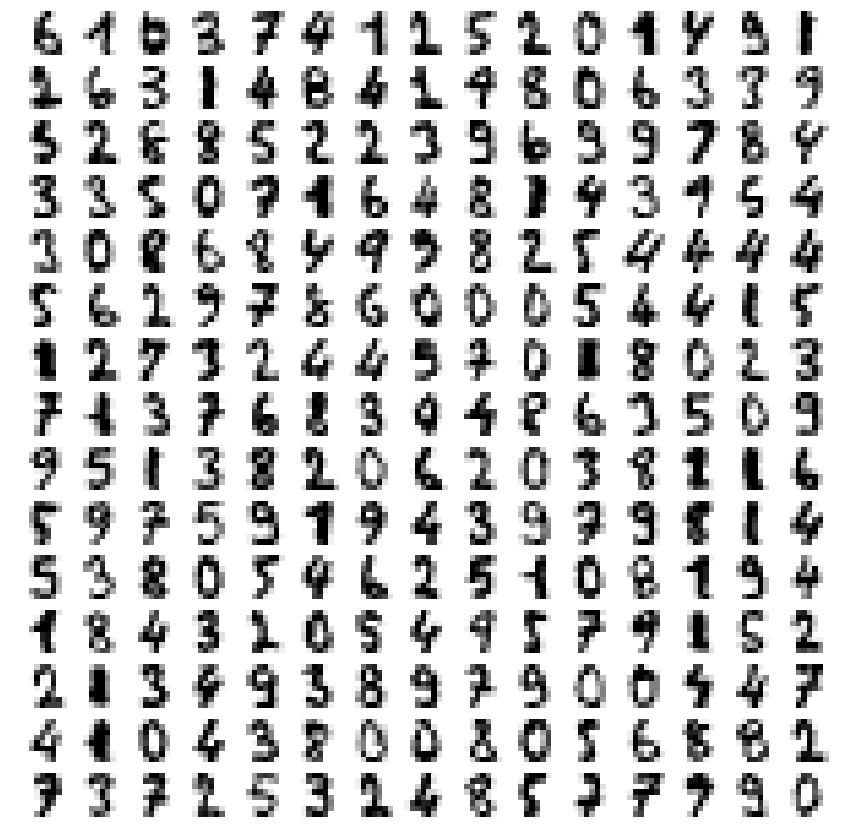

In [6]:
showImages(img_train,stride=2,invert=True)
plt.axis('off');
plt.gcf().canvas.set_window_title('Digits from database')


### K-means
Here, K-means is tested with values of K ranging from 1 to 15. The controids extracted from K-means 



In [7]:
from sklearn import cluster
from sklearn.metrics import confusion_matrix

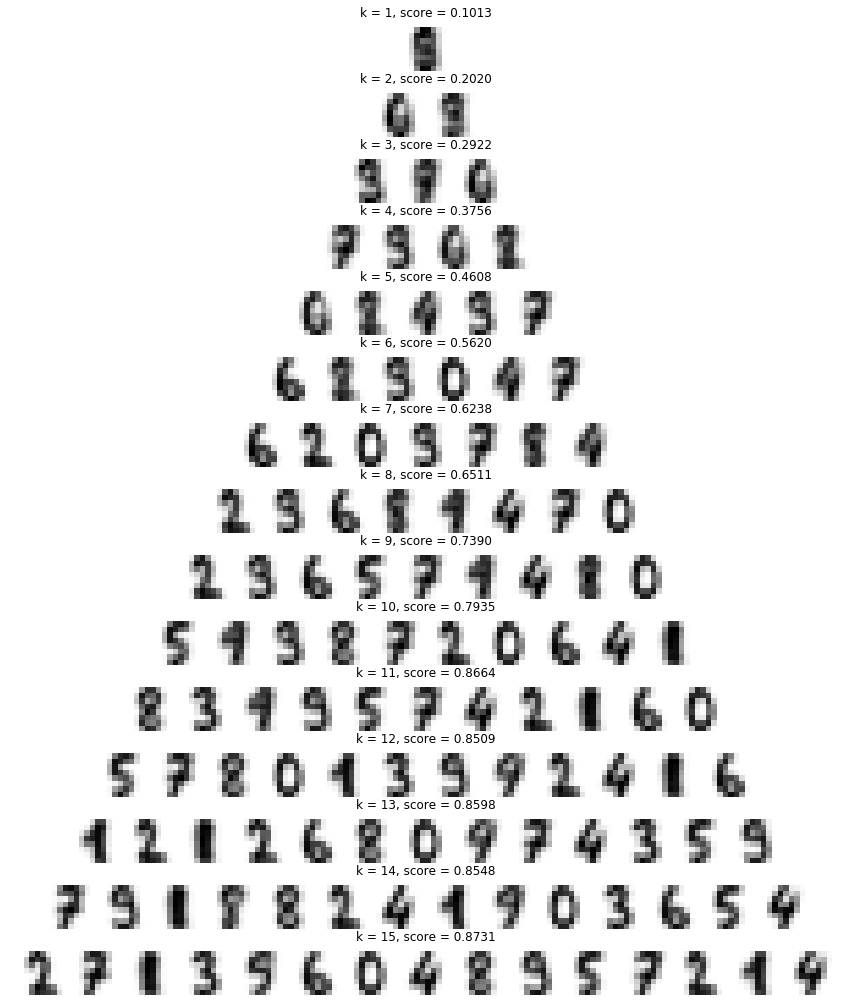

In [8]:
# Show cluster centers for k in [1,15]
conf_mat = dict()
k_tested = range(1,16)
nk = len(k_tested)

fig = plt.figure(figsize=(nk,nk*1.2))
fig.canvas.set_window_title('Centroids of each cluster')

for ii,k in enumerate(k_tested):
    kmean = cluster.KMeans(n_clusters=k,random_state=9999)
    rl = ReLabeler()
    
    labels = kmean.fit_predict(X_train)
    true_labels = rl.fit_transform(labels,y_train)
    
    lab_test=rl.transform(kmean.predict(X_test))
    score=(lab_test==y_test).mean()
    
    showImages(kmean.cluster_centers_.reshape((-1,8,8)),stride=2,invert=True,nimg=(1,k),subplot=(nk,1,ii+1))
    plt.axis('off')
    plt.title("k = %d, score = %.4f"%(k,score))
    
    conf_mat[k] = confusion_matrix(y_test, lab_test, labels=[ii for ii in range(10)]) 


In [9]:
for k_choice in [11,15]:

    print('confusion matrix for k = %d'%k_choice)
    print("_"*69)
    print("| True  |" + " "*21 + "Predicted  labels" + " "*21 + "|")
    print("| label |  " + "  |  ".join(["%d"%jj for jj in range(10)]) + "  |" )
    print("|==" + "=====|"*11)
    for ii in range(10):
        print('|   %d   | '%ii + " | ".join(["%3d"%nb for nb in conf_mat[k_choice][ii,:]]) + " |")
    print("="*69)
    print()

confusion matrix for k = 11
_____________________________________________________________________
| True  |                     Predicted  labels                     |
| label |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |
|=======|=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|
|   0   | 176 |   0 |   0 |   0 |   2 |   0 |   0 |   0 |   0 |   0 |
|   1   |   0 | 156 |  21 |   1 |   0 |   1 |   3 |   0 |   0 |   0 |
|   2   |   1 |   4 | 151 |   4 |   0 |   0 |   0 |   4 |  10 |   3 |
|   3   |   0 |   1 |   1 | 155 |   0 |   2 |   0 |   8 |   5 |  11 |
|   4   |   0 |  10 |   0 |   0 | 159 |   0 |   0 |   7 |   5 |   0 |
|   5   |   0 |   0 |   0 |   0 |   1 | 145 |   1 |   0 |   0 |  35 |
|   6   |   1 |   4 |   0 |   0 |   0 |   0 | 175 |   0 |   1 |   0 |
|   7   |   0 |   8 |   0 |   0 |   1 |   1 |   0 | 166 |   3 |   0 |
|   8   |   0 |  28 |   1 |   1 |   0 |   2 |   1 |   1 | 132 |   8 |
|   9   |   0 |  24 |   0 |   3 |   0 |   4 |   0 |   4 |   3 